# 02_Model_Training.ipynb

## Cel

Celem tego notebooka jest:
- Wczytanie i przygotowanie przetworzonych danych (train_preprocessed.csv i test_preprocessed.csv).
- Podział danych na zbiór treningowy i walidacyjny:
- Definicja funkcji oceny modelu:
    - RMSLE (Root Mean Squared Logarithmic Error).
- Trenowanie modeli regresyjnych do przewidywania cen nieruchomości:
    - Regresja Grzbietowa (Ridge Regression, regularyzacja L2),
    - Gradient Boosting Regressor (ensemble boosting).
    - XGBoost Regressor (Extreme Gradient Boosting),
    - Sieć Neuronowa (Deep Learning – TensorFlow/Keras).
- Ocena modeli na zbiorze walidacyjnym przy użyciu metryk:
    - RMSLE (Root Mean Squared Logarithmic Error),
    - Porównanie wyników modeli na podstawie jakości predykcji.
- Predykcja cen nieruchomości dla zbioru testowego i zapis wyników w wymaganym formacie CSV:
    - ridge_regression_predictions.csv
    - gradient_boosting_predictions.csv
    - xgboost_predictions.csv
    - neural_network_predictions.csv


## Kroki

**1. Import niezbędnych bibliotek**

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from pathlib import Path
import matplotlib.pyplot as plt

**2. Wczytanie, przygotowanie danych**
- Podział na cechy (X) i zmienną docelową (y)
- Podział na dane treningowe i walidacyjne

In [92]:
train_df = pd.read_csv("../Data/Preprocessed/a_train_preprocessed.csv")
test_df = pd.read_csv("../Data/Preprocessed/a_test_preprocessed.csv")

X_train = train_df.drop(columns=["Id", "SalePrice"])
y_train = train_df["SalePrice"]

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Dane zostały wczytane i podzielone na zbiory treningowe i walidacyjne.")


Dane zostały wczytane i podzielone na zbiory treningowe i walidacyjne.


**3. Definicje funkcji pomocniczych**

In [93]:
def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 1e-9) 
    y_pred = np.maximum(y_pred, 1e-9)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    return np.sqrt(np.mean((log_true - log_pred) ** 2))

evaluation_results = []

def evaluate_model(model_name, y_true, y_pred, is_log_transformed=False):
    if is_log_transformed:
        y_true = np.expm1(y_true) 
        y_pred = np.expm1(y_pred)  
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle_value = rmsle(y_true, y_pred)
    
    print(f"\nWyniki modelu {model_name}:")
    print(f"  R²    : {r2:.4f}")
    print(f"  RMSE  : {rmse:.4f}")
    print(f"  RMSLE : {rmsle_value:.4f}")
    
    evaluation_results.append({
        "Model": model_name,
        "R²": r2,
        "RMSE": rmse,
        "RMSLE": rmsle_value
    })

def save_predictions(model, X_test, test_ids, filename, is_log_transformed=False):
    predictions = model.predict(X_test)
    if is_log_transformed:
        predictions = np.expm1(predictions.flatten())
    predictions = predictions.flatten() if hasattr(predictions, 'flatten') else predictions
    submission_df = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": predictions
    })
    Path(filename).parent.mkdir(parents=True, exist_ok=True)
    submission_df.to_csv(filename, index=False)
    print(f"Przewidywania zapisano w pliku: {filename}")


**4. Ridge Regression**

In [94]:
print("\nTrening modelu Ridge Regression...")
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train_split, np.log1p(y_train_split))
y_val_pred_ridge = ridge_reg.predict(X_val)
evaluate_model("Ridge Regression", np.log1p(y_val), y_val_pred_ridge, is_log_transformed=True)



Trening modelu Ridge Regression...

Wyniki modelu Ridge Regression:
  R²    : 0.9173
  RMSE  : 25179.6576
  RMSLE : 0.1378


**5. Gradient Boosting Regression**

In [95]:
print("\nTrening modelu Gradient Boosting Regression...")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_split, np.log1p(y_train_split))
y_val_pred_gb = gb_model.predict(X_val)
evaluate_model("Gradient Boosting Regression", np.log1p(y_val), y_val_pred_gb, is_log_transformed=True)



Trening modelu Gradient Boosting Regression...

Wyniki modelu Gradient Boosting Regression:
  R²    : 0.9043
  RMSE  : 27099.3628
  RMSLE : 0.1367


**6. XGBoost Regression**

In [96]:
print("\nTrening modelu XGBoost Regression...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=0)
xgb_model.fit(X_train_split, np.log1p(y_train_split))
y_val_pred_xgb = xgb_model.predict(X_val)
evaluate_model("XGBoost Regression", np.log1p(y_val), y_val_pred_xgb, is_log_transformed=True)



Trening modelu XGBoost Regression...

Wyniki modelu XGBoost Regression:
  R²    : 0.9104
  RMSE  : 26214.1165
  RMSLE : 0.1434


**7. Sieć neuronowa**


Trening sieci neuronowej...


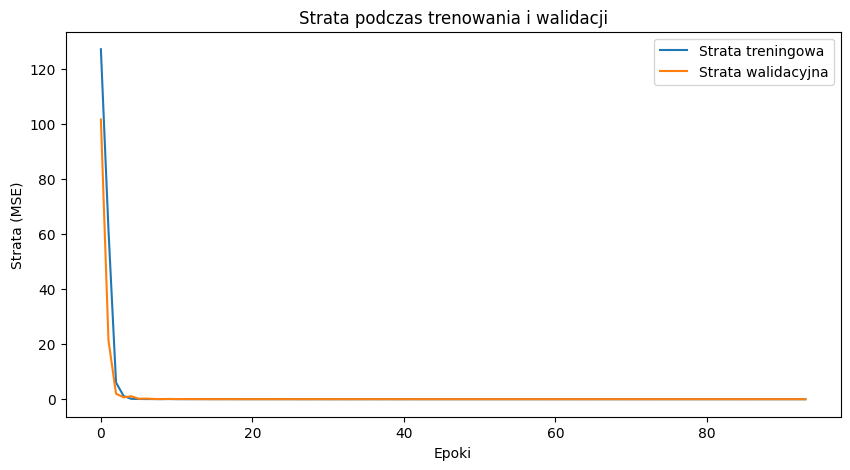

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Wyniki modelu Neural Network:
  R²    : 0.8375
  RMSE  : 35299.8693
  RMSLE : 0.1597


In [97]:
print("\nTrening sieci neuronowej...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  
    Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dense(1)  
])

model.compile(optimizer=Adam(learning_rate=0.01), loss="mse", metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=0)

history = model.fit(
    X_train_scaled, np.log1p(y_train_split),
    validation_data=(X_val_scaled, np.log1p(y_val)),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Strata treningowa")
plt.plot(history.history["val_loss"], label="Strata walidacyjna")
plt.xlabel("Epoki")
plt.ylabel("Strata (MSE)")
plt.legend()
plt.title("Strata podczas trenowania i walidacji")
plt.show()

y_val_pred_nn = model.predict(X_val_scaled).flatten()
evaluate_model("Neural Network", np.log1p(y_val), y_val_pred_nn, is_log_transformed=True)


**8. Podsumowanie wyników ewaluacji**

In [98]:
print("\nPodsumowanie wyników ewaluacji:")
results_df = pd.DataFrame(evaluation_results)
print(results_df)



Podsumowanie wyników ewaluacji:
                          Model        R²          RMSE     RMSLE
0              Ridge Regression  0.917342  25179.657608  0.137838
1  Gradient Boosting Regression  0.904258  27099.362774  0.136689
2            XGBoost Regression  0.910411  26214.116530  0.143371
3                Neural Network  0.837545  35299.869280  0.159736


**8. Zapisanie przewidywań dla zbioru testowego**

In [99]:
print("\nPrzygotowanie danych testowych...")
X_test = test_df.drop(columns=["Id"], errors="ignore")
X_test_scaled = scaler.transform(X_test)
test_ids = test_df["Id"]

models = {
    "Ridge Regression": (ridge_reg, True),
    "Gradient Boosting Regression": (gb_model, True),
    "XGBoost Regression": (xgb_model, True),
    "Neural Network": (model, True)
}

for model_name, (model_instance, is_log_transformed) in models.items():
    print(f"\nZapisywanie przewidywań dla {model_name}...")
    save_predictions(
        model_instance,
        X_test_scaled if model_name == "Neural Network" else X_test,
        test_ids,
        f"../Data/Results/{model_name.replace(' ', '_').lower()}_predictions.csv",
        is_log_transformed=is_log_transformed
    )



Przygotowanie danych testowych...

Zapisywanie przewidywań dla Ridge Regression...
Przewidywania zapisano w pliku: ../Data/Results/ridge_regression_predictions.csv

Zapisywanie przewidywań dla Gradient Boosting Regression...
Przewidywania zapisano w pliku: ../Data/Results/gradient_boosting_regression_predictions.csv

Zapisywanie przewidywań dla XGBoost Regression...
Przewidywania zapisano w pliku: ../Data/Results/xgboost_regression_predictions.csv

Zapisywanie przewidywań dla Neural Network...
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Przewidywania zapisano w pliku: ../Data/Results/neural_network_predictions.csv
